<a href="https://colab.research.google.com/github/Aurora-Fund-Analytics/forecast-model/blob/main/notebooks/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction model testing

In [ ]:
!pip install yfinance torch numpy pandas scikit-learn matplotlib

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

In [3]:
# -------------------
# Reload Data & Scaler
# -------------------
ticker = "E1VFVN30.VN"
new_df = yf.download(ticker, start="2025-01-01", end="2025-08-27")
features = ['Open', 'High', 'Low', 'Close', 'Volume']
new_data = new_df[features].values

# ⚠️ Ideally load the scaler you saved during training
# Here, we'll refit using all available historical data (train + new)
full_df = yf.download(ticker, start="2015-01-01", end="2025-08-27")
full_data = full_df[features].values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_full = scaler.fit_transform(full_data)

# Use only the latest portion for inference
scaled_new = scaled_full[-len(new_data):]

SEQ_LEN = 60
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/tmp/ipython-input-616765360.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  new_df = yf.download(ticker, start="2025-01-01", end="2025-08-27")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-616765360.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  full_df = yf.download(ticker, start="2015-01-01", end="2025-08-27")
[*********************100%***********************]  1 of 1 completed


In [4]:
# -------------------
# Reload Model
# -------------------
class LSTMModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out.squeeze()

model = LSTMModel(input_size=len(features))
model.load_state_dict(torch.load("lstm_stock_model.pth", map_location=device))
model.to(device)
model.eval()

LSTMModel(
  (lstm): LSTM(5, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [5]:
# -------------------
# Predict Next 30 Days
# -------------------
last_seq = scaled_full[-SEQ_LEN:].copy()  # last 60 days
preds = []

for _ in range(30):  # predict 30 days ahead
    seq_tensor = torch.tensor(last_seq, dtype=torch.float32).unsqueeze(0).to(device)  # (1, seq_len, features)
    with torch.no_grad():
        pred_scaled = model(seq_tensor).cpu().numpy()

    # build dummy vector to inverse only Close
    dummy = np.zeros((1, len(features)))
    dummy[:, 3] = pred_scaled  # Close
    pred_real = scaler.inverse_transform(dummy)[:, 3][0]

    preds.append(pred_real)

    # append prediction back into sequence (recursive forecasting)
    next_step = last_seq[-1].copy()
    next_step[3] = pred_scaled  # replace Close with predicted
    last_seq = np.vstack([last_seq[1:], next_step])

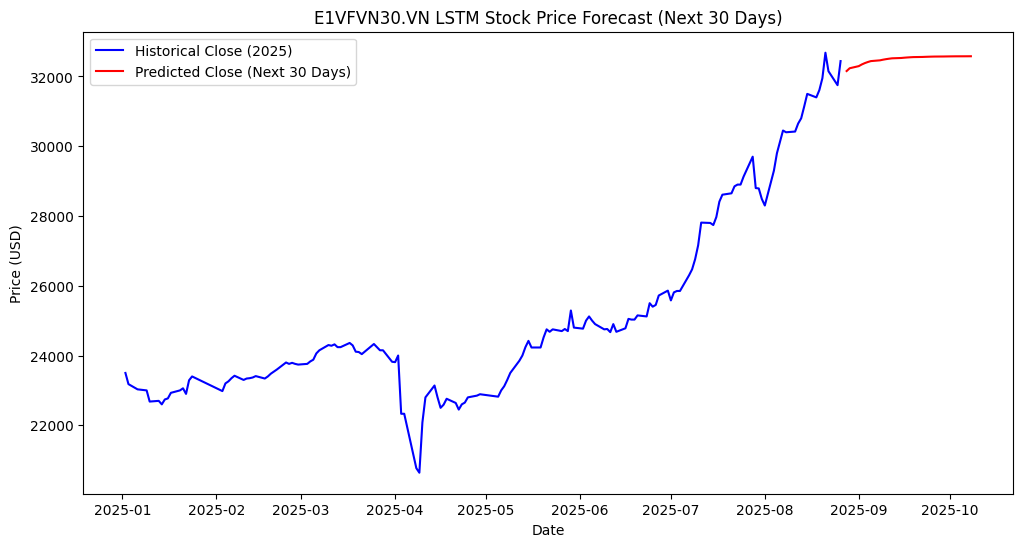

In [6]:
# -------------------
# Plot Predictions
# -------------------
plt.figure(figsize=(12, 6))
plt.plot(new_df.index, new_df['Close'], label="Historical Close (2025)", color="blue")
future_dates = pd.date_range(start="2025-08-28", periods=30, freq="B")  # next 30 business days
plt.plot(future_dates, preds, label="Predicted Close (Next 30 Days)", color="red")
plt.legend()
plt.title(f"{ticker} LSTM Stock Price Forecast (Next 30 Days)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()